In [1]:
# import load_iris function from datasets module
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.metrics import f1_score
import csv
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.cluster import KMeans # KMeans clustering 
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline 
from gensim.models import word2vec
from sklearn import svm
from sklearn import ensemble

In [2]:
#Load csv data
with open("movie_metadata.csv", 'rb') as f:
    raw_data = list(csv.reader(f))
        

In [3]:
#clean the dataset by ignoring it if any column is empty or equal to 0

data = []
counter = 0
for row in raw_data:
    qualified = True
    for column in row:
        if column == " "or column == 0 or column =="0":
            qualified = False
    if qualified:
        data.append(row)
    counter = counter + 1

#the size of the current dataset right now
print len(data)

1298


In [4]:
movie = pd.read_csv('movie_metadata.csv') # reads the csv and creates the dataframe called movie
movie.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [5]:
#plot_keywords -> numerical values
#dictioinarize the plot keywords section with their corresponding imdb_score
plot_keywords_dic = {}
for index, row in movie.iterrows():
    words_array = str(row["plot_keywords"]).split("|")
    for word in words_array:
        if word not in plot_keywords_dic:
            plot_keywords_dic[word] = []
        plot_keywords_dic[word].append(row["imdb_score"])

#compute the average of all the plot keywords in the dictionary
for key, elem in plot_keywords_dic.items():
    plot_keywords_dic[key] = sum(elem)/len(elem)

        
#convert the orignal movie value to the sum of the top five keywords foundable in the training dataset
for index, row in movie.iterrows():
    words_array = str(row["plot_keywords"]).split("|")
    plot_value = 0
    counter = 0
    i = 0
    while counter < 5 and i < len(words_array):
        if(words_array[i] in plot_keywords_dic):
            plot_value = plot_value + plot_keywords_dic[words_array[i]]
            counter = counter + 1
        i = i + 1
    movie.set_value(index,'plot_keywords',plot_value)
    

#Genres -> Column Feature
genre_list = []
for index, row in movie.iterrows():
    words_array = str(row["genres"]).split("|")
    for word in words_array:
        if word not in genre_list:
            genre_list.append(word)
            
for movie_genre in genre_list:
    movie[movie_genre] = pd.Series(0,index=movie.index)
    
#convert the orignal movie value to the sum of the top five keywords foundable in the training dataset
for index, row in movie.iterrows():
    words_array = str(row["genres"]).split("|")
    for word in words_array:
        movie.set_value(index,word,1)
    

#Country -> Index
country_dic = {}
for index, row in movie.iterrows():
    word = str(row["country"])
    if word not in country_dic:
        country_dic[word] = [1]
        
country_index = 1
#assign each country an index number
for key, elem in country_dic.items():
    country_dic[key] = country_index
    country_index = country_index+1
    
for index, row in movie.iterrows():
    word = str(row["country"])
    movie.set_value(index,'country',country_dic[word])
    

In [6]:
# converting director_name, actor1_name, actor2_name, actor3_name, content rating, and language to numeric values

director_map = {}
count = 0
for name in movie["director_name"]:
    if not director_map.has_key(str(name)):
        #dict[str(name)] = count
        director_map.update({str(name): count})
        count+=1
#print director_map

#for index, row in movie_data.iterrows():
#    if not str(row['director_name']) in director_map:
#        director_map.update({str(row['director_name']): len(director_map)})
#    movie_data.set_value(index, 'director_name', director_map[str(row['director_name'])])
        
# converting actor1 to values
actor1_map = {}
actor1_count = 0
for name in movie["actor_1_name"]:
    #print name
    if not actor1_map.has_key(str(name)):
        actor1_map.update({str(name): actor1_count})
        actor1_count+=1
#print actor1_map        

#for index, row in movie_data.iterrows():
#    movie_data.set_value(index, 'actor_1_name', actor1_map[str(row['actor_1_name'])])

# converting actor2 to values
actor2_map = {}
actor2_count = 0
for name in movie["actor_2_name"]:
    if not actor2_map.has_key(str(name)):
        actor2_map.update({str(name): actor2_count})
        actor2_count+=1
        
#for index, row in movie_data.iterrows():
#    movie_data.set_value(index, 'actor_2_name', actor2_map[str(row['actor_2_name'])])

# converting actor3 to values
actor3_map = {}
actor3_count = 0
for name in movie["actor_3_name"]:
    if not actor3_map.has_key(str(name)):
        actor3_map.update({str(name): actor3_count})
        actor3_count+=1
        
rating_map = {}
rating_count = 0
for rating in movie["content_rating"]:
    if not str(rating) in rating_map:
        rating_map.update({str(rating): rating_count})
        rating_count+=1
        #print rating
        
language_map = {}
language_count = 0
for language in movie["language"]:
    if not str(language) in language_map:
        language_map.update({str(language): language_count})
        language_count+=1
        
for index, row in movie.iterrows():
    movie.set_value(index, 'director_name', director_map[str(row['director_name'])])
    movie.set_value(index, 'actor_1_name', actor1_map[str(row['actor_1_name'])])
    movie.set_value(index, 'actor_2_name', actor2_map[str(row['actor_2_name'])])
    movie.set_value(index, 'actor_3_name', actor3_map[str(row['actor_3_name'])])    
    movie.set_value(index, 'language', language_map[str(row['language'])])
    movie.set_value(index, 'content_rating', rating_map[str(row['content_rating'])])
    
movie.head()

str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in movie.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
    
#include the column name if applicable 
str_list.append("imdb_score")
            

# Get to the numeric columns by inversion            
num_list = movie.columns.difference(str_list)  

In [7]:
movie_num = movie[num_list]
#del movie # Get rid of movie df as we won't need it now
#movie_num.head()

#Remove some existing features generated after the movie is screening
del movie_num['gross']
del movie_num['num_critic_for_reviews']
del movie_num['num_user_for_reviews']

In [8]:
movie_num = movie_num.fillna(value=0, axis=1)
X = movie_num.values
#print movie_num.head()
# Data Normalization
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

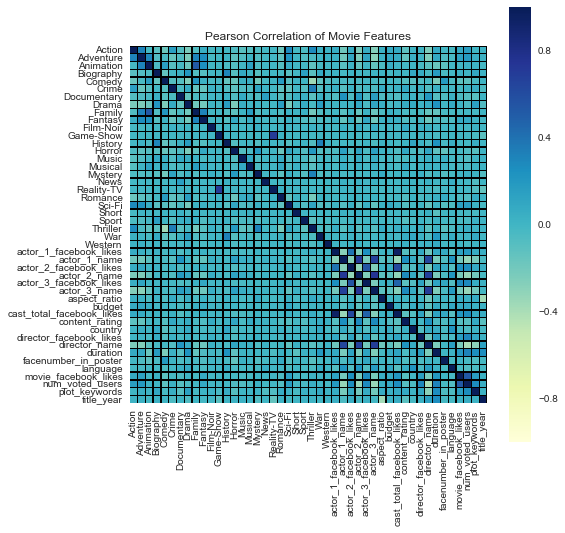

In [9]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(movie_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black')

#Pearson Correlation shows how does each variable corelate to each other
#1 means totally linear correlation, 0 means no correlation and -1 means totally negative linear correlation

In [10]:
#explained variance measure
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [11]:
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance
#print cum_var_exp

In [12]:
# PLOT OUT THE EXPLAINED VARIANCES SUPERIMPOSED 
# plt.figure(figsize=(8, 5))
# plt.bar(range(16), var_exp, alpha=0.3333, align='center', label='individual explained variance', color = 'g')
# plt.step(range(16), cum_var_exp, where='mid',label='cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal components')
# plt.legend(loc='best')
# plt.show()
#The graph indicates that roughly 8 PCA varaible can reach 80% accuracy
#14 PCA variables can reach 98% accuracy

In [13]:
#PCA

pca = PCA(n_components=9)
x_9d = pca.fit_transform(X_std)

#x_9d is the dataset that contains the PCA(9) of the movie variable data

In [14]:
# make 5 folds
print len(movie_num)

# there are 5043 samples, so we will have 1008 in 4 training sets, and 1011 in the test set
x_folds = []
y_folds = []
x_folds.append(movie_num[0:1007].values.tolist())
y_folds.append(movie["imdb_score"][0:1007].values.T.tolist())
x_folds.append(movie_num[1008:2015].values.tolist())
y_folds.append(movie["imdb_score"][1008:2015].values.T.tolist())
x_folds.append(movie_num[2016:3023].values.tolist())
y_folds.append(movie["imdb_score"][2016:3023].values.T.tolist())
x_folds.append(movie_num[3024:4031].values.tolist())
y_folds.append(movie["imdb_score"][3024:4031].values.T.tolist())
x_folds.append(movie_num[4032:5042].values.tolist())
y_folds.append(movie["imdb_score"][4032:5042].values.T.tolist())

# set the test set to be the 5th fold
x_test_set = x_folds[4]
y_test_set = y_folds[4]

# now merge the 4 folds in 4 different ways for cross validation
X_training_sets = []
Y_training_sets = []

X_validation_sets = []
Y_validation_sets = []

# merge folds 0,1,2, leave fold 3 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[0].extend(x_folds[0])
Y_training_sets[0].extend(y_folds[0])
X_training_sets[0].extend(x_folds[1])
Y_training_sets[0].extend(y_folds[1])
X_training_sets[0].extend(x_folds[2])
Y_training_sets[0].extend(y_folds[2])

X_validation_sets.append([])
X_validation_sets[0].extend(x_folds[3])
Y_validation_sets.append([])
Y_validation_sets[0].extend(y_folds[3])

# merge folds 1,2,3 leave fold 0 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[1].extend(x_folds[1])
Y_training_sets[1].extend(y_folds[1])
X_training_sets[1].extend(x_folds[2])
Y_training_sets[1].extend(y_folds[2])
X_training_sets[1].extend(x_folds[3])
Y_training_sets[1].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[1].extend(x_folds[0])
Y_validation_sets.append([])
Y_validation_sets[1].extend(y_folds[0])

# merge folds 0,2,3 leave fold 1 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[2].extend(x_folds[0])
Y_training_sets[2].extend(y_folds[0])
X_training_sets[2].extend(x_folds[2])
Y_training_sets[2].extend(y_folds[2])
X_training_sets[2].extend(x_folds[3])
Y_training_sets[2].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[2].extend(x_folds[1])
Y_validation_sets.append([])
Y_validation_sets[2].extend(y_folds[1])

# merge folds 0,1,3 leave fold 2 for validation
X_training_sets.append([])
Y_training_sets.append([])
X_training_sets[3].extend(x_folds[0])
Y_training_sets[3].extend(y_folds[0])
X_training_sets[3].extend(x_folds[1])
Y_training_sets[3].extend(y_folds[1])
X_training_sets[3].extend(x_folds[3])
Y_training_sets[3].extend(y_folds[3])

X_validation_sets.append([])
X_validation_sets[3].extend(x_folds[2])
Y_validation_sets.append([])
Y_validation_sets[3].extend(y_folds[2])

#print X_validation_sets

5043


In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

x_training_4folds = [] 
y_training_4folds = []
x_training_4folds.extend(movie_num[0:4031].values.tolist())
y_training_4folds.extend(movie["imdb_score"][0:4031].values.T.tolist())

print len(x_training_4folds)
print len(y_training_4folds)

clf = LinearRegression(normalize=True)
print clf.get_params()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_search = GridSearchCV(LinearRegression(),parameters, cv=4)
grid_search.fit(x_training_4folds, y_training_4folds)

#grid_search.best_params_
#print "For the Logistic Regression: "
print "Best parameter value is: ", grid_search.best_params_

clf = LinearRegression(copy_X=True, normalize=True, n_jobs=1, fit_intercept=True)
clf.fit(x_training_4folds, y_training_4folds)
y_test_pred = clf.predict(x_test_set)
mean_sq_error =  metrics.mean_squared_error(y_test_set, y_test_pred)

#print "Predicted value", clf.predict(x_test_set[0])
#print "Actual value", y_test_set[0]

#print "Predicted value", clf.predict(x_test_set[1])
#print "Actual value", y_test_set[1]

#print "Predicted value", clf.predict(x_test_set[2])
#print "Actual value", y_test_set[2]

print "Mean Squared Error: ", mean_sq_error
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

4031
4031
{'copy_X': True, 'normalize': True, 'n_jobs': 1, 'fit_intercept': True}


/Users/Elliscope/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Best parameter value is:  {'copy_X': True, 'normalize': True, 'fit_intercept': True}
Mean Squared Error:  1.26976202893
Mean absolute error:  0.814387347112
Explained Variance:  0.243329106183
R2:  0.196685908767


In [16]:
#print movie_num.get_item[0]
#print type(movie_num)

training_set_imdb_score = movie["imdb_score"]
training_set_features = movie_num

x_training_4folds, y_training_4folds

#map(list, df.values)
#training_set = []
#map(training_set,movie_num[0:4000].values)
training_set =  movie_num[0:4000].values.tolist()
training_set_imdb_score = movie["imdb_score"][0:4000].values.T.tolist()
test_set = movie_num[4001:4999].values.tolist()

print len(training_set)
print len(training_set_imdb_score)

clf = svm.SVR()
clf.fit(x_training_4folds, y_training_4folds)
y_test_pred = clf.predict(x_test_set)


mean_sq_error =  metrics.mean_squared_error(y_test_set, y_test_pred)
print "Mean Squared Error: ", mean_sq_error
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

4000
4000
Mean Squared Error:  1.55347562304
Mean absolute error:  0.963492164744
Explained Variance:  0.0198723748267
R2:  0.0171946947985


In [17]:
print "the actual value is"
print movie["imdb_score"][3999]

the actual value is
7.5


In [19]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.grid_search import GridSearchCV

# #apply randomeforestclassifier 

# # instantiate the model
# clf = RandomForestRegressor(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
# # define the parameter values that should be searched
# r_range = list(range(1, 20))

# # create a parameter grid: map the parameter names to the values that should be searched
# param_grid = dict(n_estimators=r_range)

# # instantiate the grid
# grid = GridSearchCV(clf, param_grid, cv=4, scoring='accuracy')

# # fit the grid with data
# # print x_training_4folds
# # print y_training_4folds

# grid.fit(x_training_4folds, y_training_4folds)

# grid_mean_scores_random = [result.mean_validation_score for result in grid.grid_scores_]
# print(grid_mean_scores_random)

# print "The highest accuracy that can be achieved by Random Forest is"
# print np.amax(grid_mean_scores_random)

In [20]:
#Random Forest Regression

rfg = ensemble.RandomForestRegressor(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
rfg.fit(x_training_4folds, y_training_4folds)
y_test_pred = rfg.predict(x_test_set)


mean_sq_error =  metrics.mean_squared_error(y_test_set, y_test_pred)
print "Mean Squared Error: ", mean_sq_error
print "Mean absolute error: ", metrics.mean_absolute_error(y_test_set, y_test_pred)
print "Explained Variance: ", metrics.explained_variance_score(y_test_set, y_test_pred)
print "R2: ", metrics.r2_score(y_test_set, y_test_pred)

Mean Squared Error:  0.800204455446
Mean absolute error:  0.60400990099
Explained Variance:  0.494007518362
R2:  0.493751190946
